# Weight Visualization

In this notebook, we visualize some weights connecting neurons in layer conv2d2 to the BW vs color detector neurons in InceptionV1. This notebook was used to make the figures in the "Implementation" section of the BW vs. color article, excluding the tuning curves for the NMF factors, which I've put in a separate notebook. 

Most of this code was adapted from the demo in the Colab notebook accompanying "Visualizing Weights" in the circuits thread: https://distill.pub/2020/circuits/visualizing-weights/.

In [1]:
import numpy as np
import torch
from lucent.modelzoo import inceptionv1

In [2]:
model = inceptionv1(pretrained=True)

## Visualizing the weight matrix

As a first step, we can visualize the weights connecting each BW vs color detector channel directly to channels in conv2d2.

### Get the weights

Note that the weights we'd like to view are *not* between immediately adjacent layers of InceptionV1. They're between adjacent *convolutional* layers, but there are other layers in between. So we have to decide how to put the successive weights together. Here, we'll visualize what we get just by multiplying together all of the intermediate weight tensors, ignoring non-linearities.

In the weight visualization colab notebook, Chris et al. implemented this by reverse-engineering the weights from the model's activations on a random image and taking gradients through the model, but we can also do it from direct multiplication.

In [3]:
print(model)

InceptionV1(
  (conv2d0_pre_relu_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv2d1_pre_relu_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2d2_pre_relu_conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (mixed3a_1x1_pre_relu_conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_3x3_bottleneck_pre_relu_conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_5x5_bottleneck_pre_relu_conv): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_pool_reduce_pre_relu_conv): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_3x3_pre_relu_conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
  (mixed3a_5x5_pre_relu_conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (mixed3b_1x1_pre_relu_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (mixed3b_3x3_bottleneck_pre_relu_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (mixed3b_5x5_bottleneck_pre_relu_conv): Conv2d(256, 32, 

In Pytorch, given the layers' names from print(model), we can then get the weights by calling model.layername.weight. 

Conv2d2 has 192 channels. It's followed by a maxpool layer (no weights), then a 1x1 bottleneck layer of shape (16, 192, 1, 1), then mixed3a of shape (32, 16, 5, 5):

In [4]:
mixed3a_5x5 = model.mixed3a_5x5_pre_relu_conv.weight.detach().numpy()
mixed3a_5x5_bottleneck = model.mixed3a_5x5_bottleneck_pre_relu_conv.weight.detach().numpy()

In [5]:
mixed3a_5x5.shape

(32, 16, 5, 5)

In [6]:
mixed3a_5x5_bottleneck.shape

(16, 192, 1, 1)

This means that to get the 5x5 set of expanded weights between a channel in conv2d2 and one in mixed3a, we should specialize to those particular indices in the tensor product of weights.

In [7]:
weights = np.reshape(np.tensordot(mixed3a_5x5, mixed3a_5x5_bottleneck, axes=((1),(0))),(32,5,5,192))

We'd like to create a nice visual of this weight matrix between the BW channels and the maximally connected channels in conv2d2. (As a reference, the BW channels in mixed3a_5x5 are
- Edge detector: 5, 9, 16, 18, 22, 31
- Point detector: 12, 28
- BW detector: 30.)

To do this, we'll borrow the following code from the linked colab notebook above.

First, two lines to convert hex color codes to RGB ... 

In [34]:
H = lambda S: int(S, 16)/255
C = lambda X: np.asarray([H(X[0:2]), H(X[2:4]), H(X[4:6])])

In [9]:
# E.g.

C("f7f7f7")

array([0.96862745, 0.96862745, 0.96862745])

Then a function to convert (negative <> positive) values to (blue <> red) colors.

In [10]:
def weight_color_scale(x):
    if x < 0:
        x = -x
        if x < 0.5:
            x = x*2
            return (1-x)*C("f7f7f7") + x*C("92c5de")
        else:
            x = (x-0.5)*2
            return(1-x)*C("92c5de") + x*C("0571b0")
    else:
        if x < 0.5:
            x = x*2
            return (1-x)*C("f7f7f7") + x*C("f4a582")
        else:
            x = (x-0.5)*2
            return (1-x)*C("f4a582") + x*C("ca0020")

Finally, this line converts a size (a,b) array to size (a,b,3 = RGB channels of the weight color scale) for visualization.

In [11]:
weight_heatmap = lambda X: np.asarray([[weight_color_scale(x) for x in X_] for X_ in X])

In [12]:
def whm(i, o):
    return weight_heatmap(weights[i, :,:,o] / abs(weights[i, :,:,o]).max())

As a check, this code leads to the same visualiations for our hand-multiplied weight tensor as obtained in the Weight Explorer tool at https://distill.pub/2020/circuits/early-vision/. E.g. here are the weights connecting mixed3a:208 to the most strongly connected channel in conv2d2:

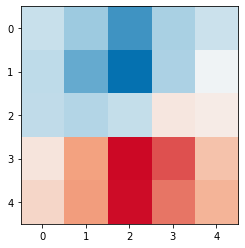

In [13]:
import matplotlib.pyplot as plt
plt.imshow(whm(16, 58))
plt.show()

and for mixed3a:222,

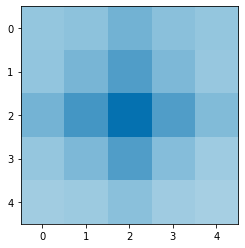

In [14]:
import matplotlib.pyplot as plt
plt.imshow(whm(30, 43))
plt.show()

Since all of this looks to be in order, let's make the weight matrix table. I did this by brute force.

In [15]:
import matplotlib.pyplot as plt
import imageio
from matplotlib.image import imread

In [16]:
mixed3a_197 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/mixed3a_197.jpg')
mixed3a_201 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/mixed3a_201.jpg')
mixed3a_204 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/mixed3a_204.jpg')
mixed3a_208 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/mixed3a_208.jpg')
mixed3a_210 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/mixed3a_210.jpg')
mixed3a_214 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/mixed3a_214.jpg')
mixed3a_220 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/mixed3a_220.jpg')
mixed3a_222 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/mixed3a_222.jpg')
mixed3a_223 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/mixed3a_223.jpg')

In [17]:
conv2d2_36 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/conv2d2_36.jpg')
conv2d2_120 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/conv2d2_120.jpg')
conv2d2_101 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/conv2d2_101.jpg')
conv2d2_43 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/conv2d2_43.jpg')
conv2d2_178 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/conv2d2_178.jpg')
conv2d2_92 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/conv2d2_92.jpg')
conv2d2_59 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/conv2d2_59.jpg')
conv2d2_86 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/conv2d2_86.jpg')
conv2d2_23 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/conv2d2_23.jpg')
conv2d2_58 = imageio.imread('https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/images/neuron/conv2d2_58.jpg')

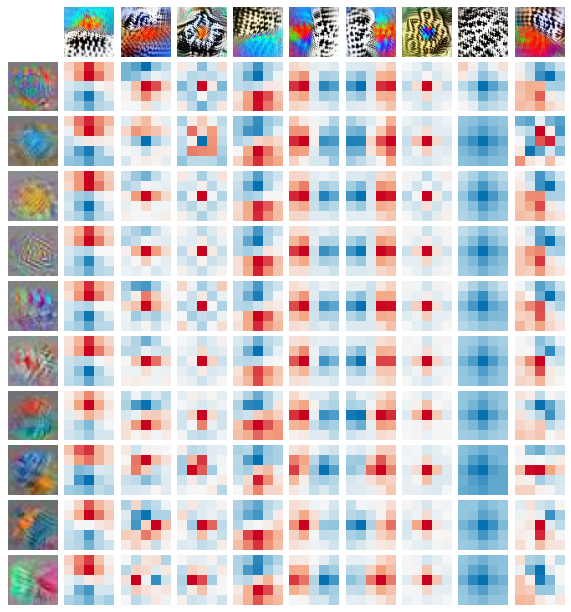

In [18]:
fig, ax = plt.subplots(11, 10, figsize=(10,11))
plt.subplots_adjust(wspace= 0.1, hspace =0.1)
[axi.set_axis_off() for axi in ax.ravel()]
ax[1,0].imshow(conv2d2_58)
ax[2,0].imshow(conv2d2_23)
ax[3,0].imshow(conv2d2_86)
ax[4,0].imshow(conv2d2_59)
ax[5,0].imshow(conv2d2_92)
ax[6,0].imshow(conv2d2_178)
ax[7,0].imshow(conv2d2_43)
ax[8,0].imshow(conv2d2_101)
ax[9,0].imshow(conv2d2_120)
ax[10,0].imshow(conv2d2_36)
ax[0,1].imshow(mixed3a_197)
ax[1,1].imshow(whm(5, 58))
ax[2,1].imshow(whm(5, 23))
ax[3,1].imshow(whm(5, 86))
ax[4,1].imshow(whm(5, 59))
ax[5,1].imshow(whm(5, 92))
ax[6,1].imshow(whm(5, 178))
ax[7,1].imshow(whm(5, 43))
ax[8,1].imshow(whm(5, 101))
ax[9,1].imshow(whm(5, 120))
ax[10,1].imshow(whm(5, 36))
ax[0,2].imshow(mixed3a_201)
ax[1,2].imshow(whm(9, 58))
ax[2,2].imshow(whm(9, 23))
ax[3,2].imshow(whm(9, 86))
ax[4,2].imshow(whm(9, 59))
ax[5,2].imshow(whm(9, 92))
ax[6,2].imshow(whm(9, 178))
ax[7,2].imshow(whm(9, 43))
ax[8,2].imshow(whm(9, 101))
ax[9,2].imshow(whm(9, 120))
ax[10,2].imshow(whm(9, 36))
ax[0,3].imshow(mixed3a_204)
ax[1,3].imshow(whm(12, 58))
ax[2,3].imshow(whm(12, 23))
ax[3,3].imshow(whm(12, 86))
ax[4,3].imshow(whm(12, 59))
ax[5,3].imshow(whm(12, 92))
ax[6,3].imshow(whm(12, 178))
ax[7,3].imshow(whm(12, 43))
ax[8,3].imshow(whm(12, 101))
ax[9,3].imshow(whm(12, 120))
ax[10,3].imshow(whm(12, 36))
ax[0,4].imshow(mixed3a_208)
ax[1,4].imshow(whm(16, 58))
ax[2,4].imshow(whm(16, 23))
ax[3,4].imshow(whm(16, 86))
ax[4,4].imshow(whm(16, 59))
ax[5,4].imshow(whm(16, 92))
ax[6,4].imshow(whm(16, 178))
ax[7,4].imshow(whm(16, 43))
ax[8,4].imshow(whm(16, 101))
ax[9,4].imshow(whm(16, 120))
ax[10,4].imshow(whm(16, 36))
ax[0,5].imshow(mixed3a_210)
ax[1,5].imshow(whm(18, 58))
ax[2,5].imshow(whm(18, 23))
ax[3,5].imshow(whm(18, 86))
ax[4,5].imshow(whm(18, 59))
ax[5,5].imshow(whm(18, 92))
ax[6,5].imshow(whm(18, 178))
ax[7,5].imshow(whm(18, 43))
ax[8,5].imshow(whm(18, 101))
ax[9,5].imshow(whm(18, 120))
ax[10,5].imshow(whm(18, 36))
ax[0,6].imshow(mixed3a_214)
ax[1,6].imshow(whm(22, 58))
ax[2,6].imshow(whm(22, 23))
ax[3,6].imshow(whm(22, 86))
ax[4,6].imshow(whm(22, 59))
ax[5,6].imshow(whm(22, 92))
ax[6,6].imshow(whm(22, 178))
ax[7,6].imshow(whm(22, 43))
ax[8,6].imshow(whm(22, 101))
ax[9,6].imshow(whm(22, 120))
ax[10,6].imshow(whm(22, 36))
ax[0,7].imshow(mixed3a_220)
ax[1,7].imshow(whm(28, 58))
ax[2,7].imshow(whm(28, 23))
ax[3,7].imshow(whm(28, 86))
ax[4,7].imshow(whm(28, 59))
ax[5,7].imshow(whm(28, 92))
ax[6,7].imshow(whm(28, 178))
ax[7,7].imshow(whm(28, 43))
ax[8,7].imshow(whm(28, 101))
ax[9,7].imshow(whm(28, 120))
ax[10,7].imshow(whm(28, 36))
ax[0,8].imshow(mixed3a_222)
ax[1,8].imshow(whm(30, 58))
ax[2,8].imshow(whm(30, 23))
ax[3,8].imshow(whm(30, 86))
ax[4,8].imshow(whm(30, 59))
ax[5,8].imshow(whm(30, 92))
ax[6,8].imshow(whm(30, 178))
ax[7,8].imshow(whm(30, 43))
ax[8,8].imshow(whm(30, 101))
ax[9,8].imshow(whm(30, 120))
ax[10,8].imshow(whm(30, 36))
ax[0,9].imshow(mixed3a_223)
ax[1,9].imshow(whm(31, 58))
ax[2,9].imshow(whm(31, 23))
ax[3,9].imshow(whm(31, 86))
ax[4,9].imshow(whm(31, 59))
ax[5,9].imshow(whm(31, 92))
ax[6,9].imshow(whm(31, 178))
ax[7,9].imshow(whm(31, 43))
ax[8,9].imshow(whm(31, 101))
ax[9,9].imshow(whm(31, 120))
ax[10,9].imshow(whm(31, 36))
plt.show()

## NMF

Next up, we'll run NMF on the expanded weight tensor connecting conv2d2 and the BW channels of mixed3a.

In [19]:
from lucid.misc.io import collapse_channels
from lucid.misc.channel_reducer import ChannelReducer

/home/guest/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [20]:
from lucent.optvis import render, transform, param, objectives

In [21]:
BW_units = [5, 9, 12, 16, 18, 22, 28, 30, 31] 
BW_edge_units = [5, 9, 16, 18, 22, 31] 
BW_point_units = [12, 28]
BW = [30]
all_units = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

In [22]:
W_2d_3a = weights.transpose(1,2,3,0).reshape(5,5,192,32)

"Hyperparameters" for n-component NMF from conv2d2 to N of the channels in mixed3a:

In [23]:
n_components = 2
units = BW_units
N = len(units)

Then run the following cell to perform NMF.

Line by line,

- W_ extracts the channels of interest and puts the mixed3a channels in the 1st axis.
- W_posneg makes the 1st dim. twice as big with entries (abs(previously), 0) for performing NMF.
- We then implement NMF by calling sklearn.decomposition.NMF(n_comonents), which returns matrices (W_nmf, H) whose product approximates the argument X. ChannelReducer is a wrapper around sklearn.decomposiiton that lets us apply it to (the last axis of) tensors. E.g., it takes a tensor of shape (2#B&W, 5, 5, 192) to (2#B&W, 5, 5, 2) * (2,192).

In [30]:
W_ = W_2d_3a[..., units].transpose(-1, 0, 1, 2) 
W_posneg = np.concatenate([np.maximum(0, W_), np.maximum(0, -W_)], axis=0) 

NMF = ChannelReducer(n_components)

W_nmf = NMF.fit_transform(W_posneg)
W_nmf /= W_nmf.max()
H1 = NMF.components

(Previously, we ran this cell with n_components = 1 to decide which channels to put along the LHS of the weight matrix above.)

We can now read off the channels in conv2d2 with the largest arguments to make the diagrams in the section "Implementation/Black-and-white and color factors".

In [31]:
# Color factor
np.argsort(-H1[0])[0:5]

array([58, 23, 86, 59, 92])

In [32]:
# Black-and-white factor.
np.argsort(-H1[1])[0:5]

array([ 29,  90,  67, 189,  70])

Just for fun, we can also do some feature visualizations using the NMF vectors as objectives in Lucent/Lucid.

100%|██████████| 512/512 [02:49<00:00,  3.02it/s]



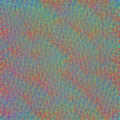
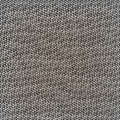

In [38]:
obj = sum(objectives.direction("conv2d2", torch.from_numpy(H1[i]), batch=i) for i in range(n_components))
imgs_channel = render.render_vis(model, obj, param_f=lambda: param.image(120, batch=n_components), show_inline=True)[-1]

100%|██████████| 512/512 [02:23<00:00,  3.56it/s]



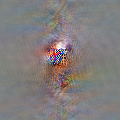
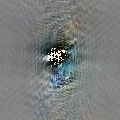

In [33]:
obj = sum(objectives.direction_neuron("conv2d2", torch.from_numpy(H1[i]), batch=i) for i in range(n_components))
imgs_neuron = render.render_vis(model, obj, param_f=lambda: param.image(120, batch=n_components), show_inline=True)[-1]

## ImageNet-vs.-grayscale activations on the NMF factors

We copy over the code from the "Imagenet activations" notebook to make the plots of the activations of the NMF factors on a subset of ImageNet images vs. on those images converted to grayscale.

In [40]:
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485,0.456,0.406],
    std=[0.229,0.224,0.225])
])

In [41]:
cd

/home/guest


In [43]:
import torchvision
imagenet_data = torchvision.datasets.ImageNet('Downloads/ImageNet', transform=transform)

In [44]:
imagenet_data

Dataset ImageNet
    Number of datapoints: 950002
    Root location: Downloads/ImageNet
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [48]:
trainloader = torch.utils.data.DataLoader(imagenet_data, batch_size = 1, shuffle=True)

In [45]:
class SaveFeatures_postrelu():
    features = None
    def __init__(self, model):
        for name, module in model.named_modules():
            if name == 'conv2d2': 
                self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output 
    def close(self):
        self.hook.remove()

In [46]:
bwactivations = np.zeros((4, 10000))

In [50]:
for i, data in enumerate(trainloader):
    images, labels = data
    probe = SaveFeatures_postrelu(model)
    out = model(images)
    probe.close()
    conv2d2_activations = torch.mean(probe.features[0], (1,2)).detach().numpy()
    bwactivations[0,i] = np.inner(conv2d2_activations, H1[0])
    bwactivations[1,i] = np.inner(conv2d2_activations, H1[1])
    probe = SaveFeatures_postrelu(model)
    out = model(images.mean(1).unsqueeze(1).repeat(1,3,1,1))
    probe.close()
    conv2d2_activations = torch.mean(probe.features[0], (1,2)).detach().numpy()
    bwactivations[2,i] = np.inner(conv2d2_activations, H1[0])
    bwactivations[3,i] = np.inner(conv2d2_activations, H1[1])
    if i % 1000 == 0: 
       print(i)
    if i == 9999:
        break

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [51]:
import seaborn as sns
sns.set(color_codes=True)

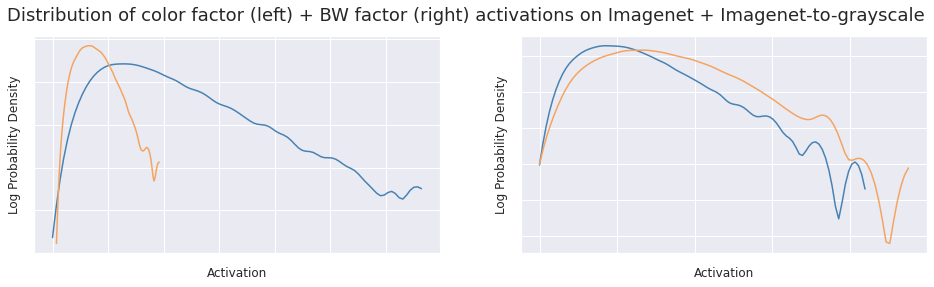

In [53]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
fig.suptitle('Distribution of color factor (left) + BW factor (right) activations on Imagenet + Imagenet-to-grayscale', fontsize=18)

p1 = sns.kdeplot(bwactivations[0],  clip=(0,166), 
                 label='color', color='steelblue', ax=ax1)
p1 = sns.kdeplot(bwactivations[2],  clip=(0,48), 
                 label='grayscale', color='sandybrown', ax=ax1)
#p1.axvline(0, color='black', linestyle='dotted')
p1.set_xlabel('Activation')
p1.set_ylabel('Log Probability Density')
p1.set_yscale("log")
#p1.set(yticklabels=[-9, -8, -4, -3, -2, -1, -3, -2])
p1.set(yticklabels=[])
p1.set(xticklabels=[])
p1.legend([],[],frameon=False)

p1 = sns.kdeplot(bwactivations[1],  clip=(0,210), 
                 label='color', color='steelblue', ax=ax2)
p1 = sns.kdeplot(bwactivations[3], clip=(0, 238),
                 label='grayscale', color='sandybrown', ax=ax2)
# p1.axvline(0, color='black', linestyle='dotted')
#p1.set_title('Distribution of B&W factor activations', fontsize=18)
p1.set_xlabel('Activation')
p1.set_ylabel('Log Probability Density')
p1.set_yscale("log")
#p1.set(yticklabels=[-8, -7, -6, -5, -4, -3, -2])
p1.set(yticklabels=[])
p1.set(xticklabels=[])
# p1.legend(loc=(1.10, 0.25))
p1.legend([],[],frameon=False)

## Visualizing the spatial arrangement of weights for the NMF factors

The table in the section "Implementation/Construction of black-and-white vs. color detectors" comes from running the same code as for the weight matrix above, but for W_nmf (shape:(18=9x2,5,5,2)) instead of whm (shape:(32,5,5,192)).

In [35]:
from lucent.misc.io import show
from lucid.misc.io.showing import _image_url, _display_html

In [36]:
def whm2(i, o):
    return weight_heatmap((W_nmf[:N] - W_nmf[N:])[i,...,o]  / abs((W_nmf[:N] - W_nmf[N:])[i,...,o]).max())

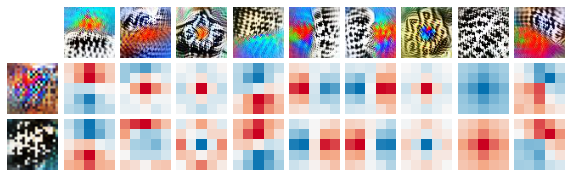

In [39]:
fig, ax = plt.subplots(3, 10, figsize=(10,3))
plt.subplots_adjust(wspace= 0.1, hspace =0.1)
[axi.set_axis_off() for axi in ax.ravel()]
ax[0,1].imshow(mixed3a_197)
ax[0,2].imshow(mixed3a_201)
ax[0,3].imshow(mixed3a_204)
ax[0,4].imshow(mixed3a_208)
ax[0,5].imshow(mixed3a_210)
ax[0,6].imshow(mixed3a_214)
ax[0,7].imshow(mixed3a_220)
ax[0,8].imshow(mixed3a_222)
ax[0,9].imshow(mixed3a_223)
ax[1,0].imshow(imgs_neuron[0][47:67, 47:67, :])
ax[1,1].imshow(whm2(0, 0))
ax[1,2].imshow(whm2(1, 0))
ax[1,3].imshow(whm2(2, 0))
ax[1,4].imshow(whm2(3, 0))
ax[1,5].imshow(whm2(4, 0))
ax[1,6].imshow(whm2(5, 0))
ax[1,7].imshow(whm2(6, 0))
ax[1,8].imshow(whm2(7, 0))
ax[1,9].imshow(whm2(8, 0))
ax[2,0].imshow(imgs_neuron[1][47:67, 47:67, :])
ax[2,1].imshow(whm2(0, 1))
ax[2,2].imshow(whm2(1, 1))
ax[2,3].imshow(whm2(2, 1))
ax[2,4].imshow(whm2(3, 1))
ax[2,5].imshow(whm2(4, 1))
ax[2,6].imshow(whm2(5, 1))
ax[2,7].imshow(whm2(6, 1))
ax[2,8].imshow(whm2(7, 1))
ax[2,9].imshow(whm2(8, 1))